In [1]:
import json
import bz2
import regex
from tqdm import tqdm
from scipy import sparse
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
responses = []
with bz2.BZ2File('/content/drive/MyDrive/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:30, 1333.62it/s]


#  Домашнее задание по NLP # 2 [100 баллов]
## Составление словарей для классификации по тональности
При классификации текстов или предложений по тональности необходимо использовать оценочные словари для предметной области, то есть, такие словари, в которых содержатся отрицательные и позитивные слова для какой-то предметной области. Идея подобных словарей основана на следующих наблюдениях: во-первых, для разных товаров используются разные оценочные слова (например бывает “захватывающая книга”, но не бывает “захватывающих лыж”), во-вторых, в контексте разных товаров одни и те же слова могут иметь разную окраску (слово “тормоз” в отзыве на велосипед имеет нейтральную окраску, в отзыве на компьютер – резко негативную, “пыль” в контексте пылесосов – нейтральную, в контексте кофемолок – положительную (“мелкий помол в пыль”)). Еще один пример: "теплое пиво" – это плохо, а "теплый свитер" – это хорошо.  

Составление таких словарей в ручную – трудоемкий процесс, но, к счастью, его не сложно автоматизировать, если собрать достаточно большие корпуса отзывов. В этом домашнем задании вам предстоит попробовать реализовать один их подходов к составлению оценочных словарей, основанный на статье Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora (https://nlp.stanford.edu/pubs/hamilton2016inducing.pdf).


Данные для задания – уже знакомые вам отзывы на банки, собранные с нескольких сайтов Рунета. Отзывы могут быть как положительными (оценка 5), так и отрицательными (оценка 1).

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Обучение модели word2vec [50 баллов]

1. Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.
2. Обучите по коллекции предложений word2vec
3. Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
    * тест на определение ближайших слов
    * тест на аналогии (мужчина – король : женщина – королева)
    * тест на определение лишнего слова.
    
4. Постройте несколько визуализаций:
    * TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
    * задайте координаты для нового пространства следующим образом: одна  ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах.  Более формально:
    берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.  



Ссылка на примеры визуализаций: https://towardsdatascience.com/game-of-thrones-word-embeddings-does-r-l-j-part-2-30290b1c0b4b

In [5]:
import re
from gensim.models.word2vec import Word2Vec
from pymystem3 import Mystem
from string import punctuation
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

1. Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова

In [6]:
regex = re.compile('[А-ЯЁа-яё]+')
MORPH = Mystem()
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также', '']
mystopwords.remove('хорошо')

In [7]:
sentences = []
for text in tqdm(responses):
    for sent in nltk.sent_tokenize(text['text']):
        sent = ' '.join(regex.findall(sent)).lower()
        sentences.append([word.strip() for word in MORPH.lemmatize(sent) if word.strip() not in mystopwords])

100%|██████████| 153499/153499 [52:20<00:00, 48.88it/s] 


2. Обучите по коллекции предложений word2vec

In [8]:
model_banks = Word2Vec(sentences, vector_size=300, min_count=3, window=5, epochs=50)

In [9]:
model_path = '/content/drive/MyDrive/w2v_banks.model'
model_banks.save(model_path)
model_banks = Word2Vec.load(model_path)

3. Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
- Тест на определение ближайших слов

In [10]:
# Удачный пример
model_banks.wv.most_similar('деньги')

[('денежки', 0.752345085144043),
 ('средство', 0.6934440732002258),
 ('денежка', 0.683441698551178),
 ('дс', 0.6541534662246704),
 ('наличка', 0.5990563631057739),
 ('наличность', 0.582828938961029),
 ('денюжка', 0.5672067403793335),
 ('кровный', 0.552567720413208),
 ('ден', 0.5374482274055481),
 ('деньга', 0.5249049663543701)]

In [11]:
# Удачный пример
model_banks.wv.most_similar('клиент')

[('вкладчик', 0.6407958269119263),
 ('пользователь', 0.4502924680709839),
 ('клиентура', 0.44776931405067444),
 ('заемщик', 0.43867027759552),
 ('посетитель', 0.425013929605484),
 ('клиентка', 0.40304529666900635),
 ('имидж', 0.3979536294937134),
 ('клиенто', 0.39330199360847473),
 ('человек', 0.39320412278175354),
 ('клиентоориентированный', 0.3835460841655731)]

In [12]:
# Не самый удачный пример
model_banks.wv.most_similar('банкир')

[('ситибанковец', 0.4657309353351593),
 ('сбербанковец', 0.42529988288879395),
 ('товарищ', 0.415762335062027),
 ('сберовец', 0.38781049847602844),
 ('альфовец', 0.38202375173568726),
 ('абдурахманов', 0.379634290933609),
 ('зауважать', 0.37771403789520264),
 ('господин', 0.36896398663520813),
 ('россиянин', 0.360804945230484),
 ('знаток', 0.3604971766471863)]

- Тест на аналогии (мужчина – король : женщина – королева)

In [13]:
# Неудачный пример
model_banks.wv.most_similar(positive=['женщина', 'клиент'], negative=['мужчина'], topn=1)

[('вкладчик', 0.5822593569755554)]

In [14]:
# Удачный пример
model_banks.wv.most_similar(positive=['хороший', 'медленный'], negative=['плохой'], topn=1)

[('быстрый', 0.5189850330352783)]

In [15]:
# Удачный пример
model_banks.wv.most_similar(positive=['прибыль', 'страдать'], negative=['убыток'], topn=1)

[('наживаться', 0.3430092930793762)]

- Тест на определение лишнего слова

In [16]:
# Удачный пример
model_banks.wv.doesnt_match('деньги монета банкнота купюра принтер'.split())

'принтер'

In [17]:
# Удачный пример
model_banks.wv.doesnt_match('кредит заем ссуда рассрочка вклад'.split())

'вклад'

In [18]:
# Неудачный пример
model_banks.wv.doesnt_match('банкир кассир операционист специалист клиент'.split())

'банкир'

4. Постройте несколько визуализаций:
- TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов

In [19]:
from sklearn.manifold import TSNE

def tsne_plot(n_top, plot=True, embedding_size=300):
    top_tokens = list(model_banks.wv.key_to_index.keys())[:n_top]
    top_embeddings = np.zeros([n_top, embedding_size])

    for i in range(n_top):
        top_embeddings[i] = model_banks.wv[top_tokens[i]]

    tsne = TSNE(n_components=2, init='random', random_state=42)
    z = tsne.fit_transform(top_embeddings)

    if plot:
        plt.figure(figsize=(12, 12))
        plt.scatter(z[:,0], z[:,1])

        for i in range(len(z)):
            plt.annotate(top_tokens[i], (z[i,0], z[i,1] + 0.2))
    else:
        return z

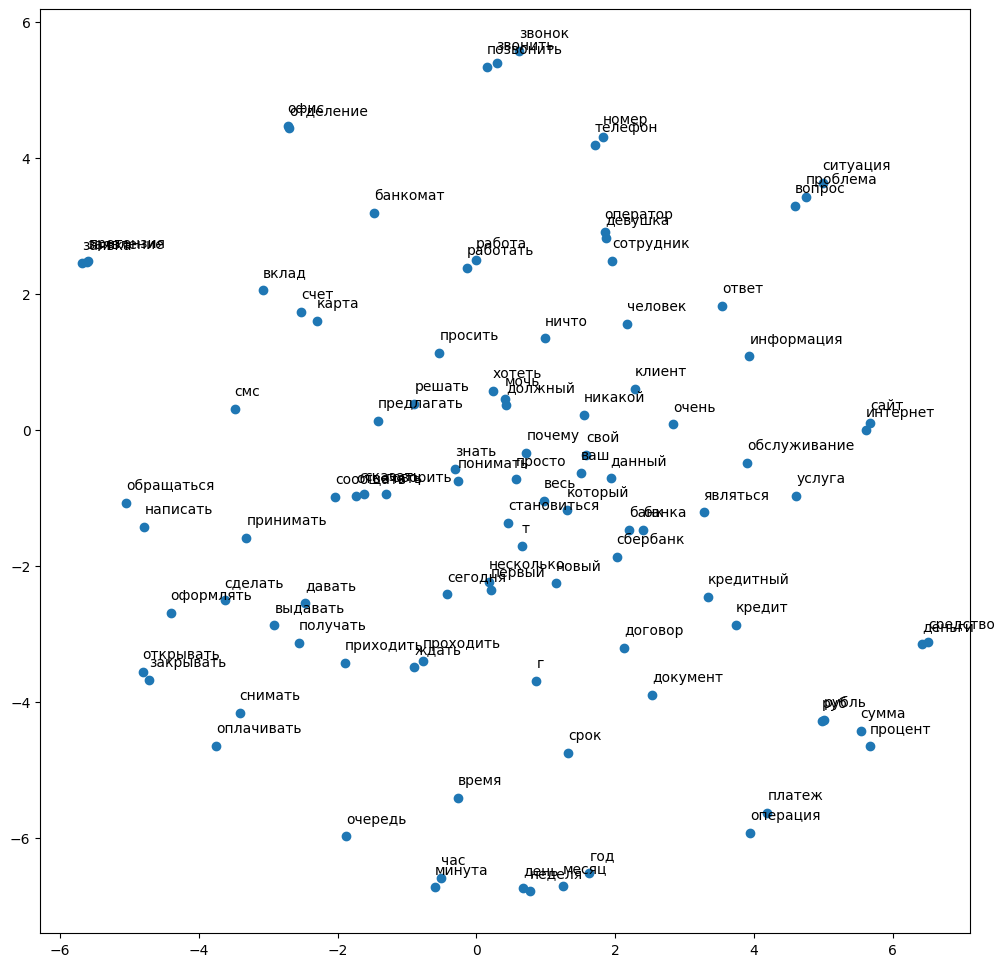

In [ ]:
tsne_plot(n_top=100)

При рассмотрении топ-100 слов уже можно заметить группировку сходных по смыслу слов в кластеры. К примеру, в верхней части графика сгруппировались слова `звонок, звонить, позвонить`, ближе всего к ним расположены кластеры слов `номер, телефон` и `офис, отделение`. Также в отдельные группы собрались слова `оператор, девушка, сотрудник` и `ситуация, проблема, вопрос`. Все это выглядит, как вполне закономерный результат работы W2V-модели.

Также в нижней части графика к одному облаку можно отнести слова `час, минута, день, неделя, месяц, год, время, срок, очередь` - то есть слова, относящиеся к течению времени. Слова `рубль, руб` почти полностью наложились друг на друга, а ближе всего к ним расположены кластеры слов `деньги, средство` и `платеж, операция`.

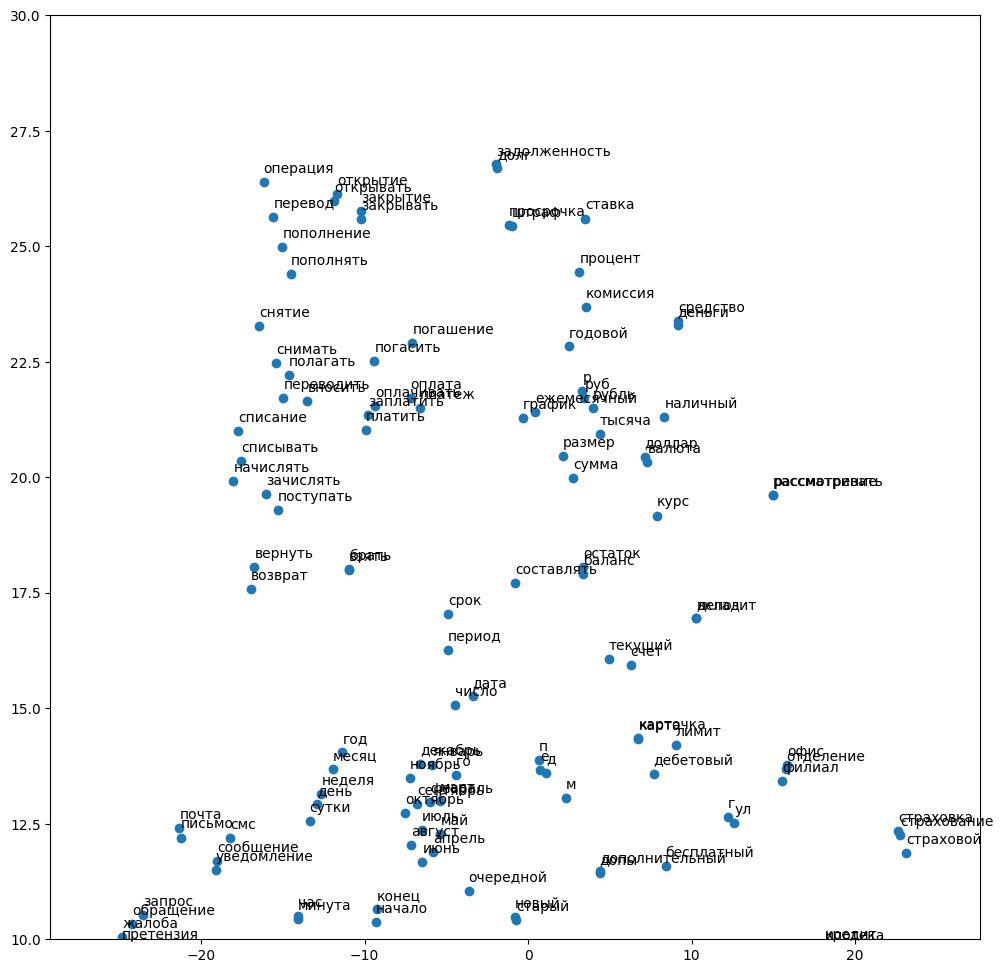

In [21]:
tsne_plot(n_top=500)
plt.ylim(10, 30);

При рассмотрении топ-500 слов также можно заметить определенные группы. На этот раз для выделения кластеров я воспользуюсь методом DBSCAN, который определит их автоматически.

In [27]:
from sklearn.cluster import DBSCAN

components = tsne_plot(n_top=500, plot=False)
clusters = DBSCAN(eps=2, min_samples=3).fit(components)
words = list(model_banks.wv.key_to_index.keys())[:500]

for label in np.random.choice(np.unique(clusters.labels_), 3):
    print([w for w, l in zip(words, clusters.labels_) if l == label])

['несколько', 'каждый', 'пара']
['просить', 'предлагать', 'попросить', 'просьба', 'требовать', 'требование']
['операция', 'перевод', 'пополнять', 'пополнение']


- Задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.

In [32]:
bad_good = model_banks.wv['хорошо'] - model_banks.wv['плохо']
slow_fast = model_banks.wv['быстро'] - model_banks.wv['медленно']

banks = '''сбербанк втб газпромбанк альфа россельхозбанк мкб совкомбанк
юникредит райффайзен росбанк ситибанк уралсиб тинькофф отп бинбанк
промсвязьбанк транскредитбанк росевробанк мособлбанк инвестбанк'''
banks = banks.split()

x_ax = []
y_ax = []

for bank in banks:
    emb = model_banks.wv[bank]
    x_ax.append((bad_good * emb).sum())
    y_ax.append((slow_fast * emb).sum())

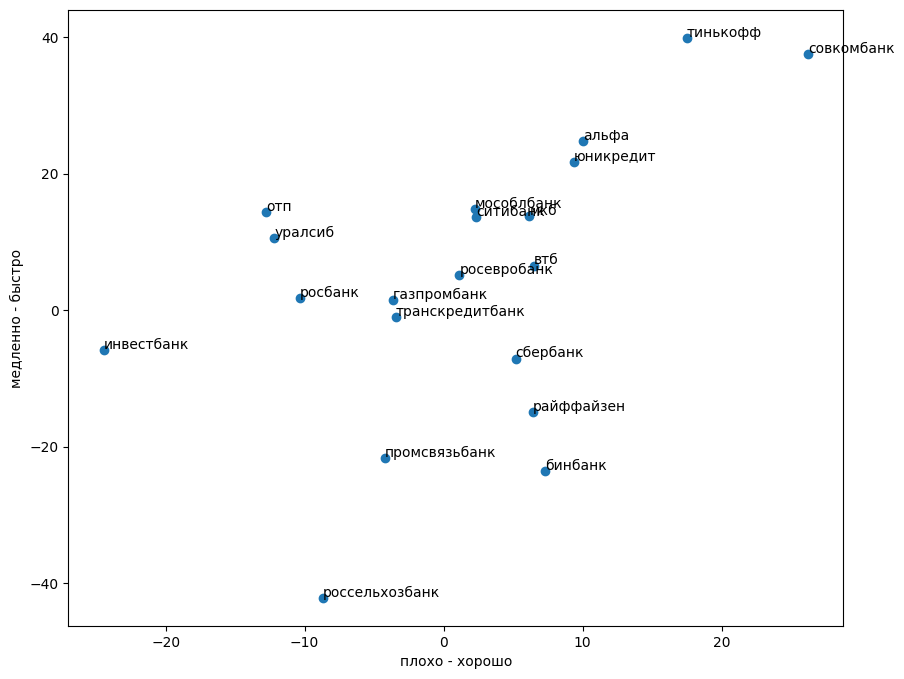

In [33]:
plt.figure(figsize=(10, 8))
plt.scatter(x_ax, y_ax)

for i in range(len(banks)):
    plt.annotate(banks[i], (x_ax[i], y_ax[i] + 0.2))

plt.xlabel('плохо - хорошо')
plt.ylabel('медленно - быстро');

## Часть 2. Распространение метки [50 баллов]

Определите 5-8 позитивных слов (например, “быстрый”, “удобный”) и 5-8  негативных слов (например,“очередь”, “медленно”). Эти слова будут основной будущего оценочного словаря. Пусть позитивному классу соответствует метка 1, негативному – -1. Пометьте выбранные слова в лексическом графе соответствующими метками. Запустите любой известный вам метод распространения метки (Label Propogation) в лексическом графе. На выходе метода распространения ошибки должны быть новые слова, помеченные метками 1 и -1 – это и есть искомые оценочные слова.

Алгоритмы распространения метки устроены примерно так: пусть мы находимся в выршине, помеченном +1. С какой-то вероятностью мы переносим эту метку на соседние узлы. С меньшей вероятностью переносим ее на вершины на расстоянии два. В конце распространения метки, часть вершин оказывается помечена меткой +1, часть – -1, большая часть остается без метки.

Рекомендуемые алгоритмы распространения метки:
1. ```graphlab.label_propagation``` (```graphlab``` доступен бесплатно по образовательной лицензии)
2. ```sklearn.semi_supervised.LabelPropagation```
3. ```sklearn.semi_supervised.LabelSpreading```

In [43]:
good = 'быстрый удобный комфорт оперативный профессионал качество вежливый выгодный'
good = good.split()

bad = 'медленный очередь неудобный убогий проблема сбой ненадлежащий бездействие'
bad = bad.split()

In [44]:
# Сокращаю размер словаря, чтобы хватило памяти на обучение алгоритма
words = list(model_banks.wv.key_to_index.keys())[:10000]

X = np.zeros([len(words), 300])
y = []

for i in range(len(words)):
    label = -1
    if words[i] in good:
        label = 1
    if words[i] in bad:
        label = 0
    y.append(label)
    X[i] = model_banks.wv[words[i]]

In [45]:
from sklearn.semi_supervised import LabelSpreading

label_prop_model = LabelSpreading(kernel='knn', n_neighbors=100)
label_prop_model.fit(X, y)

# проверю количественное распределение слов на классы
np.unique(label_prop_model.transduction_, return_counts=True)

(array([0, 1]), array([4593, 5407]))

Для проверки того, насколько хорошо алгоритм распространил метки я посмотрю на ближайшие слова для нескольких изначальных представителей позитивного и негативного класса. Ближайшим словам, при выведении на экран я буду присваивать '+', или '-' в зависимости от того, к какому классу они были отнесены алгоритмом. Так адекватность классификации можно будет оценить визуально.

In [46]:
def check_nearest(word, topn=10):
    for w, _ in model_banks.wv.most_similar(word, topn=topn):
        try:
            label = label_prop_model.transduction_[words.index(w)]
            if label:
                print(w, '+')
            else:
                print(w, '-')
        except:
            continue

In [47]:
check_nearest('быстрый')

оперативный +
быстрота +
скорость +
оперативность +
мгновенный +
качественный +
грамотный +
удобный +
моментальный +
отличный +


In [48]:
check_nearest('медленный')

медлительный -
медленно -
нерасторопный -
отвратительный -
скорость +
ужасный -
неторопливый -


In [49]:
check_nearest('комфорт')

удобство +
комфортный +
привлекательность +
открытость +
спокойствие +
привилегия +
гибкость +
защищенность +


In [50]:
check_nearest('проблема')

трудность -
вопрос -
ситуация -
недоразумение -
проблемка -
сложность -
неполадка -
затруднение -
косяк -
конфликт -
